# End-to-End Model Training with SSL4EO Backbone

This notebook outlines the training process for our most comprehensive model. We begin with a ResNet50 backbone pretrained using [MoCo](https://openaccess.thecvf.com/content_CVPR_2020/papers/He_Momentum_Contrast_for_Unsupervised_Visual_Representation_Learning_CVPR_2020_paper.pdf) on the [SSL4EO-L dataset](https://proceedings.neurips.cc/paper_files/paper/2023/file/bbf7ee04e2aefec136ecf60e346c2e61-Paper-Datasets_and_Benchmarks.pdf), sourced from [Hugging Face](https://huggingface.co/torchgeo/ssl4eo_landsat/blob/main/resnet50_landsat_etm_sr_moco-1266cde3.pth). The entire model is then fine-tuned on the IWI (Index of Wealth and Infrastructure) prediction task using mean squared error (MSE) loss and five-fold cross-validation. Following training, we compute the score function on both the training and held-out validation sets, as detailed in the associated paper.

In [1]:
import timm
import json
import os
import torch
import pandas as pd
import numpy as np
import configparser
from tqdm import tqdm
from huggingface_hub import hf_hub_download
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import gaussian_kde

sns.set(style="darkgrid")

tqdm.pandas()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

# Set up PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision("high")

# Set seeds for reproducibility
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Load the dataset
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs.csv'))
img_dir = os.path.join(DATA_DIR, 'dhs_images')

### Make folds

In [3]:
# Create equal-sized folds
folds = ['A', 'B', 'C', 'D', 'E']
df['cv_fold'] = np.nan  # Initialize the cv_fold column

# Generate and shuffle indices
indices = np.arange(len(df))
np.random.shuffle(indices)

# Split indices into equal-sized groups and assign folds
fold_indices = np.array_split(indices, len(folds))
for fold, idx in zip(folds, fold_indices):
    df.loc[idx, 'cv_fold'] = fold

df['cv_fold'].value_counts()

C    13724
B    13724
D    13724
A    13724
E    13723
Name: cv_fold, dtype: int64

### Init model

Initiate model. For more info, see https://huggingface.co/torchgeo/ssl4eo_landsat/tree/main

In [4]:
def init_model():

    repo_id = "torchgeo/ssl4eo_landsat"
    filename = "resnet50_landsat_etm_sr_moco-1266cde3.pth"

    # Download the model weights
    backbone_path = hf_hub_download(repo_id=repo_id, filename=filename)

    # Create backbone model
    state_dict = torch.load(backbone_path)
    ssl4eo_backbone = timm.create_model("resnet50", in_chans=6, num_classes=0)
    ssl4eo_backbone.load_state_dict(state_dict)

    # Define model with regression head
    model = nn.Sequential(
        ssl4eo_backbone,
        nn.Dropout(p=0.2), # Dropout layer to prevent overfitting
        nn.Linear(2048, 1)
    ).to(device, memory_format=torch.channels_last) # Use channels_last memory format for better performance on GPUs

    return model

### Data loader

Code for dataloader

In [5]:
class RegressionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cluster_id = self.df.iloc[idx]['cluster_id']
        img_path = os.path.join(self.img_dir, cluster_id, 'landsat.np')
        img = np.load(img_path)
        target = (self.df.iloc[idx]['iwi'] / 100)
        if self.transform:
            img = self.transform(img)
        return img, target

In [6]:
def get_dataloaders(df, img_dir, train_folds, val_fold, test_fold, batch_size=128, num_workers=16):

    # Get the indices for each fold
    train_folds = df[df['cv_fold'].isin(train_folds)].index.tolist()
    val_fold = df[df['cv_fold'] == val_fold].index.tolist()
    test_fold = df[df['cv_fold'] == test_fold].index.tolist()

    landsat_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 0.0000275 - 0.2),
        transforms.Lambda(lambda x: torch.clamp(x, 0.0, 0.3)),
        transforms.Lambda(lambda x: x / 0.3)
    ])

    train_transform = transforms.Compose([
        landsat_transform,
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip()
    ])

    train_dataset = RegressionDataset(df=df.iloc[train_folds], img_dir=img_dir, transform=train_transform)
    val_dataset = RegressionDataset(df=df.iloc[val_fold], img_dir=img_dir, transform=landsat_transform)
    test_dataset = RegressionDataset(df=df.iloc[test_fold], img_dir=img_dir, transform=landsat_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_dataloader, val_dataloader, test_dataloader

Train model

In [11]:
def train_model(model, train_loader, val_loader, num_epochs=20, patience=5, lr=1e-4, weight_decay=1e-5, T_0=5, T_mult=2, device=device, plot_loss=False):

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult)
    scaler = GradScaler()
    best_val_loss = float('inf')
    best_model_state = model.state_dict()
    steps_since_improvement = 0
    train_losses = []
    val_losses = []

    progress_bar = tqdm(range(num_epochs), desc="Training Progress")

    for epoch in progress_bar:
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            targets = targets.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs).squeeze()  # remove extra dim if needed
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
                targets = targets.to(device, dtype=torch.float32)
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_dataloader.dataset)
        val_losses.append(val_loss)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
        progress_bar.set_postfix({
            'Train Loss': epoch_loss,
            'Val Loss': val_loss,
            'Best Val Loss': best_val_loss
        })
        if steps_since_improvement >= patience:
            print(f"Early stopping triggered after {steps_since_improvement} epochs without improvement.")
            break

    if plot_loss:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
    
    model.load_state_dict(best_model_state)
    return model

Training for fold A...
Train folds: ['C', 'D', 'E'], Validation fold: B, Test fold: A


Training Progress: 100%|██████████| 3/3 [04:28<00:00, 89.55s/it, Train Loss=0.00949, Val Loss=0.0102, Best Val Loss=0.0102]


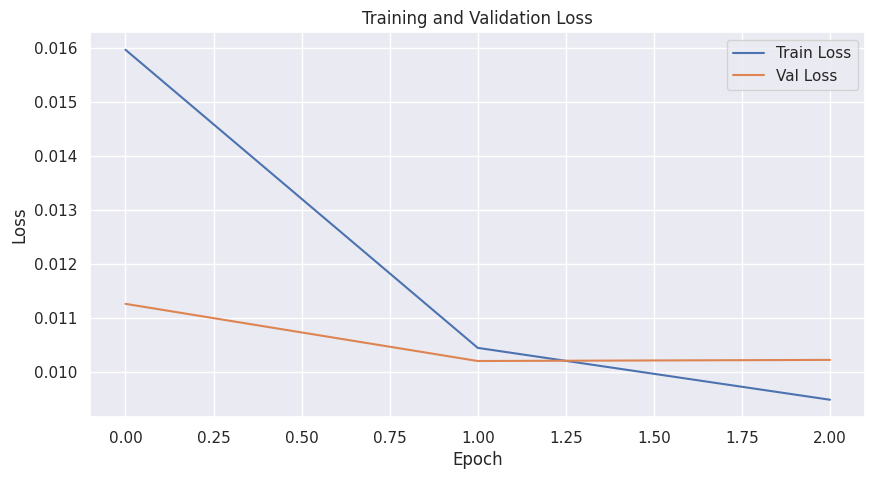

Training for fold B...
Train folds: ['A', 'D', 'E'], Validation fold: C, Test fold: B


Training Progress: 100%|██████████| 3/3 [04:27<00:00, 89.16s/it, Train Loss=0.00947, Val Loss=0.00934, Best Val Loss=0.00934]


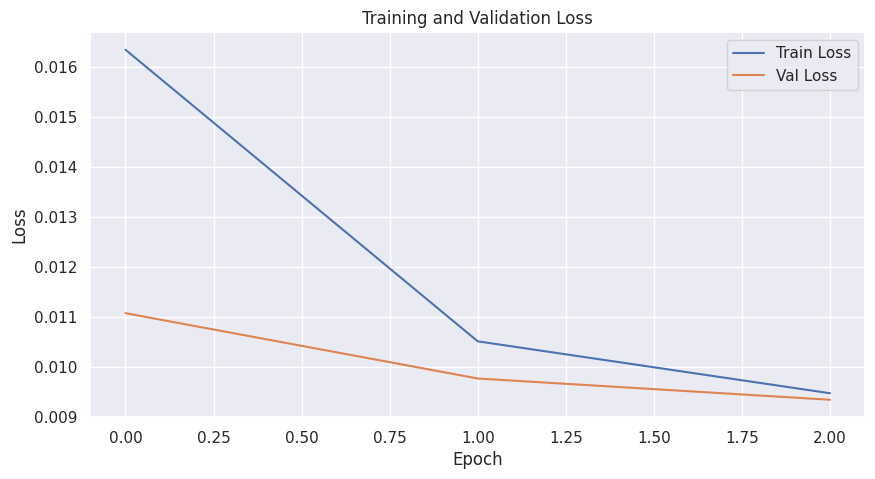

Training for fold C...
Train folds: ['A', 'B', 'E'], Validation fold: D, Test fold: C


Training Progress: 100%|██████████| 3/3 [04:26<00:00, 88.93s/it, Train Loss=0.00967, Val Loss=0.00987, Best Val Loss=0.00987]


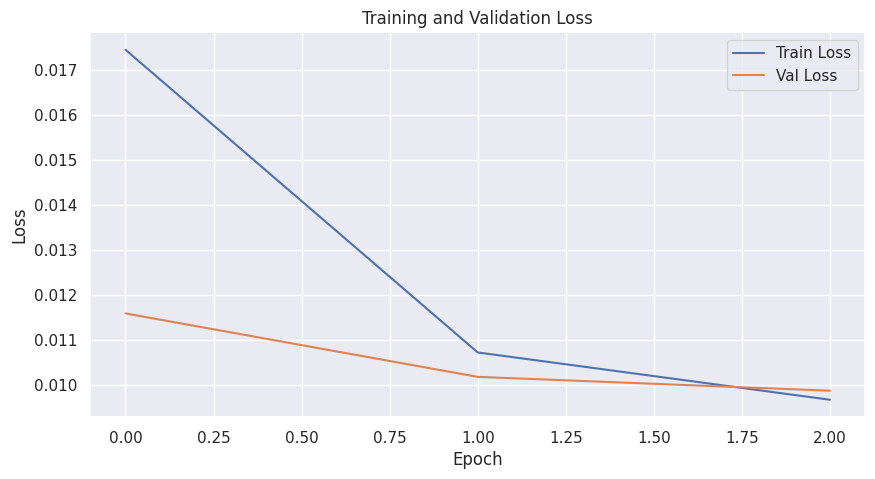

Training for fold D...
Train folds: ['A', 'B', 'C'], Validation fold: E, Test fold: D


Training Progress: 100%|██████████| 3/3 [04:25<00:00, 88.54s/it, Train Loss=0.00937, Val Loss=0.00982, Best Val Loss=0.00982]


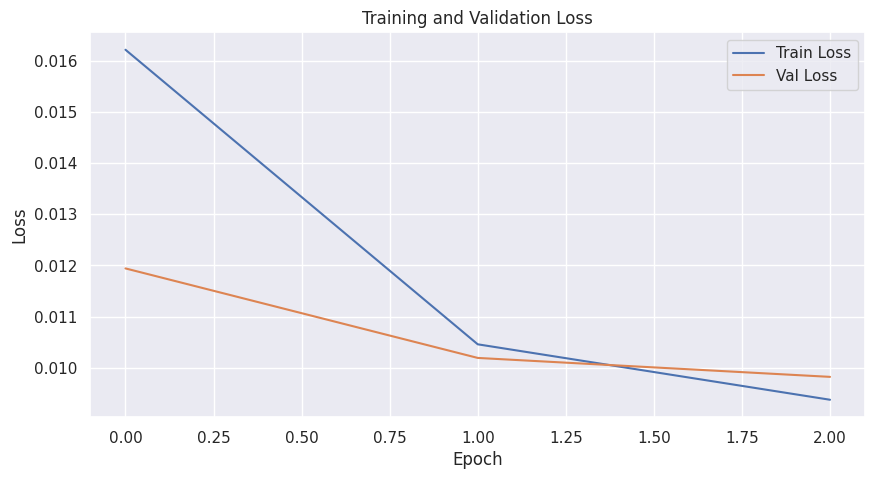

Training for fold E...
Train folds: ['B', 'C', 'D'], Validation fold: A, Test fold: E


Training Progress:   0%|          | 0/3 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x15347a37fe50>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1508, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1491, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x15347a37fe50>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x15347a37fe50>  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1508, in __del__

    self._shutdown_workers()Trac

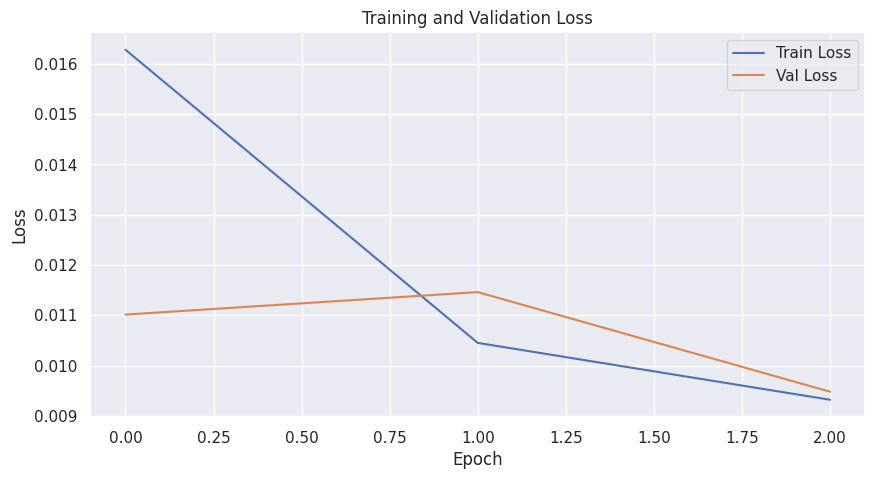

In [ ]:
for fold in folds:
    print(f"Training for fold {fold}...")

    # Define train, validation, and test folds
    test_fold = fold
    val_fold = folds[(folds.index(fold) + 1) % len(folds)]
    train_folds = [f for f in folds if f not in [test_fold, val_fold]]
    print(f"Train folds: {train_folds}, Validation fold: {val_fold}, Test fold: {test_fold}")

    # Get dataloaders
    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(df, img_dir, train_folds, val_fold, test_fold)

    # Initialize model
    model = init_model()

    # Train the model
    model = train_model(model, train_dataloader, val_dataloader, num_epochs=20, plot_loss=True, device=device)

    # Save the model
    torch.save(model.state_dict(), os.path.join(DATA_DIR, 'end_to_end_models', f'model_fold_{fold}.pth'))

Make predictions on the test set

In [7]:
metrics = {}

for fold in folds:
    print(f"Making predictions for fold {fold}...")

    # Define train, validation, and test folds
    test_fold = fold
    val_fold = folds[(folds.index(fold) + 1) % len(folds)]
    train_folds = [f for f in folds if f not in [test_fold, val_fold]]

    # Get dataloaders
    _, _, test_dataloader = get_dataloaders(df, img_dir, train_folds, val_fold, test_fold)

    # Load model
    model = init_model()
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'end_to_end_models', f'model_fold_{fold}.pth')))

    # Get test predictions
    model.eval()

    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader):
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            test_predictions.extend(outputs.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())
    test_predictions = np.array(test_predictions) * 100  # Scale back to original range
    test_targets = np.array(test_targets) * 100  # Scale back to original range

    # Store predictions in the dataframe
    fold_ixs = df['cv_fold'] == test_fold
    df.loc[fold_ixs, 'iwi_hat'] = test_predictions

    metrics[fold] = {
        'test_r2': r2_score(test_targets, test_predictions),
        'test_mae': mean_absolute_error(test_targets, test_predictions)
    }

Making predictions for fold A...


100%|██████████| 108/108 [00:20<00:00,  5.15it/s]


Making predictions for fold B...


100%|██████████| 108/108 [00:20<00:00,  5.37it/s]


Making predictions for fold C...


100%|██████████| 108/108 [00:21<00:00,  4.93it/s]


Making predictions for fold D...


100%|██████████| 108/108 [00:20<00:00,  5.28it/s]


Making predictions for fold E...


100%|██████████| 108/108 [00:20<00:00,  5.22it/s]


Calculate values used for "correction" on both train and calibration set for added flexibility

In [8]:
correction_values = {}

for fold in folds:
    print(f"Getting correction values for fold {fold}...")

    # Define train, validation, and test folds
    test_fold = fold
    val_fold = folds[(folds.index(fold) + 1) % len(folds)]
    train_folds = [f for f in folds if f not in [test_fold, val_fold]]
    print(f"Train folds: {train_folds}, Validation/Calibration fold: {val_fold}")

    # Get dataloaders
    train_dataloader, val_dataloader, _ = get_dataloaders(df, img_dir, train_folds, val_fold, test_fold)

    # Load model
    model = init_model()
    model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'end_to_end_models', f'model_fold_{fold}.pth')))

    # Get predictions for train and validation sets
    model.eval()

    train_predictions = []
    train_targets = []
    with torch.no_grad():
        for inputs, targets in tqdm(train_dataloader, desc="Training folds predictions"):
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            train_predictions.extend(outputs.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())
    train_predictions = np.array(train_predictions) * 100  # Scale back to original range
    train_targets = np.array(train_targets) * 100  # Scale back to original range

    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for inputs, targets in tqdm(val_dataloader, desc="Validation fold predictions"):
            inputs = inputs.to(device, dtype=torch.float32, memory_format=torch.channels_last)
            outputs = model(inputs).squeeze()
            val_predictions.extend(outputs.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())
    val_predictions = np.array(val_predictions) * 100  # Scale back to original range
    val_targets = np.array(val_targets) * 100  # Scale back to original range

    # Get value for Linear Correlation Correction (LCC)
    train_lcc_regressor = LinearRegression()
    train_lcc_regressor.fit(train_targets.reshape(-1, 1), train_predictions)

    val_lcc_regressor = LinearRegression()
    val_lcc_regressor.fit(val_targets.reshape(-1, 1), val_predictions)
    
    # Get sigma for Tweedie's correction (using both train and validation predictions)
    train_res_std = (train_predictions - train_targets).std()
    val_res_std = (val_predictions - val_targets).std()
    
    # Store correction values
    correction_values[fold] = {
        'train_lcc_slope': train_lcc_regressor.coef_[0],
        'train_lcc_intercept': train_lcc_regressor.intercept_,
        'val_lcc_slope': val_lcc_regressor.coef_[0],
        'val_lcc_intercept': val_lcc_regressor.intercept_,
        'train_sigma': train_res_std,
        'val_sigma': val_res_std,
        'train_predictions': list(train_predictions.astype(float)),  # Used for score function KDE
        'val_predictions': list(val_predictions.astype(float))  # Used for score function KDE
    }

    # Add metrics for train/val sets
    metrics[fold]['train_r2'] = r2_score(train_targets, train_predictions)
    metrics[fold]['train_mae'] = mean_absolute_error(train_targets, train_predictions)
    metrics[fold]['val_r2'] = r2_score(val_targets, val_predictions)
    metrics[fold]['val_mae'] = mean_absolute_error(val_targets, val_predictions)

# Store the correction values as a JSON file
with open(os.path.join(DATA_DIR, 'end_to_end_models', 'correction_values.json'), 'w') as f:
    json.dump(correction_values, f)

Getting correction values for fold A...
Train folds: ['C', 'D', 'E'], Validation/Calibration fold: B


Validation fold predictions: 100%|██████████| 108/108 [00:21<00:00,  4.95it/s]


Getting correction values for fold B...
Train folds: ['A', 'D', 'E'], Validation/Calibration fold: C


Validation fold predictions: 100%|██████████| 108/108 [00:22<00:00,  4.83it/s]


Getting correction values for fold C...
Train folds: ['A', 'B', 'E'], Validation/Calibration fold: D


Validation fold predictions: 100%|██████████| 108/108 [00:21<00:00,  5.13it/s]


Getting correction values for fold D...
Train folds: ['A', 'B', 'C'], Validation/Calibration fold: E


Validation fold predictions: 100%|██████████| 108/108 [00:20<00:00,  5.27it/s]


Getting correction values for fold E...
Train folds: ['B', 'C', 'D'], Validation/Calibration fold: A


Validation fold predictions: 100%|██████████| 108/108 [00:21<00:00,  4.99it/s]


Plot performance metrics. As expected, the loss is lower for the training set, which might cause issues further down the line

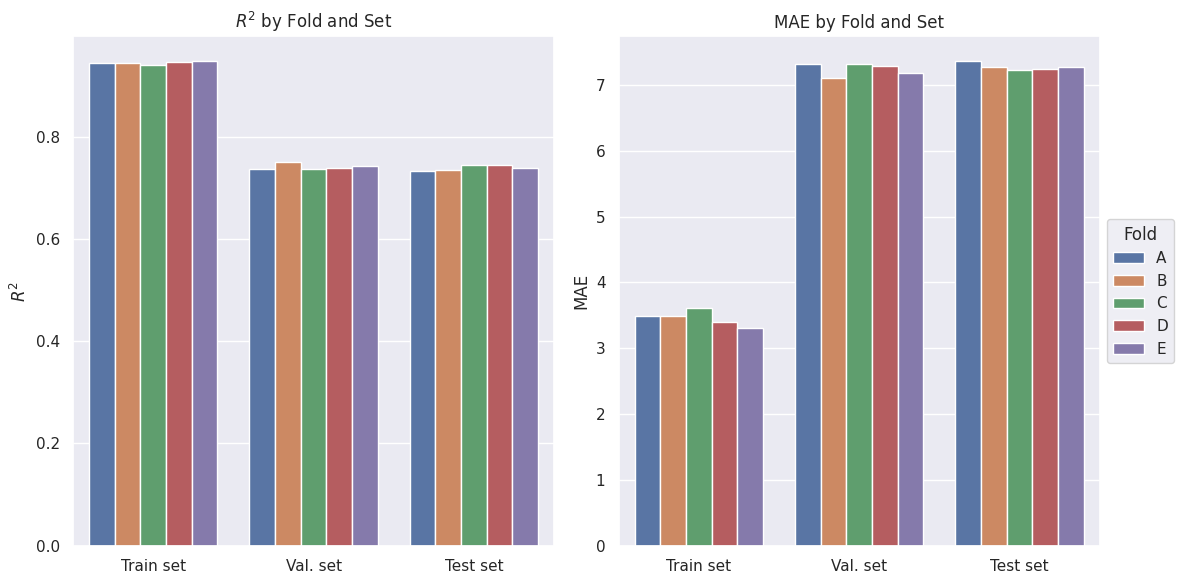

In [9]:
def plot_metrics(metrics):
    metrics_df = pd.DataFrame(metrics).T
    metrics_df.index.name = 'Fold'
    metrics_df.reset_index(inplace=True)

    # Separate R^2 and MAE metrics
    r2_metrics = metrics_df[['Fold', 'train_r2', 'val_r2', 'test_r2']].melt(id_vars='Fold', var_name='Set', value_name='R^2')
    mae_metrics = metrics_df[['Fold', 'train_mae', 'val_mae', 'test_mae']].melt(id_vars='Fold', var_name='Set', value_name='MAE')

    # Rename the 'Set' values for better readability
    r2_metrics['Set'] = r2_metrics['Set'].str.replace('train_r2', 'Train set').str.replace('val_r2', 'Val. set').str.replace('test_r2', 'Test set')
    mae_metrics['Set'] = mae_metrics['Set'].str.replace('train_mae', 'Train set').str.replace('val_mae', 'Val. set').str.replace('test_mae', 'Test set')

    # Plot R^2 metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(data=r2_metrics, x='Set', y='R^2', hue='Fold')
    plt.title(r'$R^2$ by Fold and Set')
    plt.xlabel('')
    plt.ylabel(r'$R^2$')
    plt.legend().remove()

    # Plot MAE metrics
    plt.subplot(1, 2, 2)
    sns.barplot(data=mae_metrics, x='Set', y='MAE', hue='Fold')
    plt.title('MAE by Fold and Set')
    plt.xlabel('')
    plt.ylabel('MAE')
    plt.legend(title='Fold', loc='center left', bbox_to_anchor=(1.0, 0.5))

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)

Generate KDEs for calculating score functions

In [9]:
val_kdes = {fold: gaussian_kde(correction_values[fold]['val_predictions']) for fold in folds}
train_kdes = {fold: gaussian_kde(correction_values[fold]['train_predictions']) for fold in folds}

Plot the score functions using Train vs Validation set.

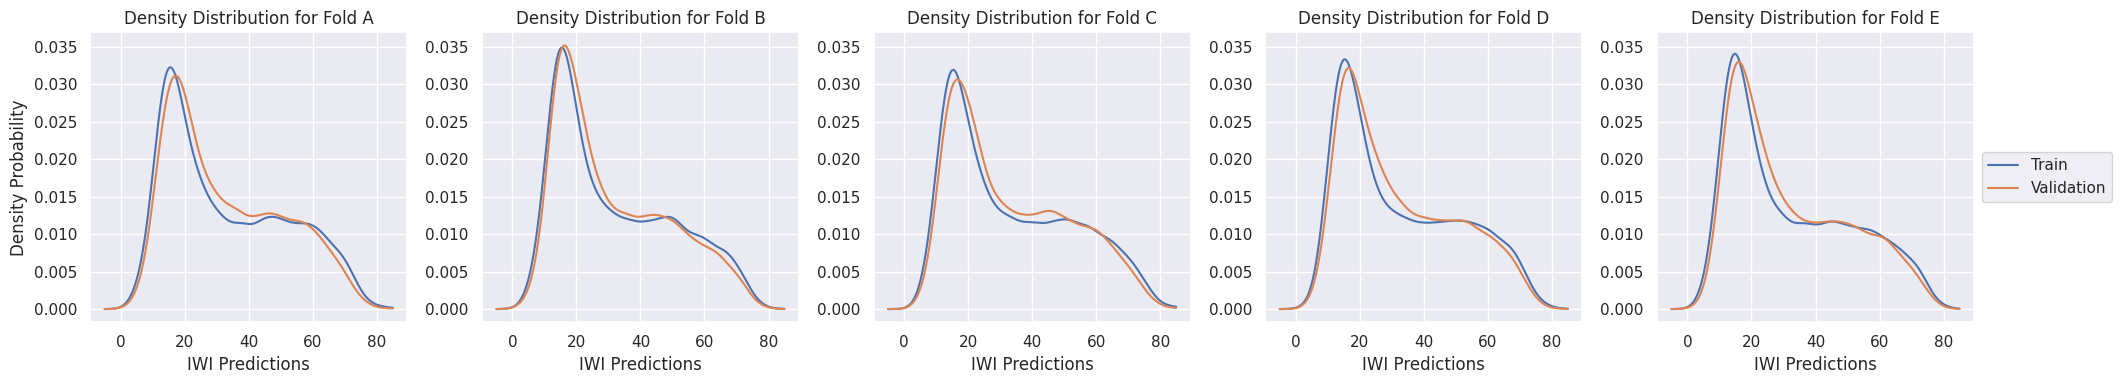

In [10]:
# Plot densities for each fold in dhs_Df
def plot_densities(train_kde, val_kde, fold):
    x = np.linspace(-5, 85, 1000)
    plt.plot(x, train_kde(x), label=f'Train')
    plt.plot(x, val_kde(x), label=f'Validation')
    plt.title(f'Density Distribution for Fold {fold}')
    plt.xlabel('IWI Predictions')

# Plot densities for each fold
plt.figure(figsize=(20, 4))
for i, fold in enumerate('ABCDE'):
    ax = plt.subplot(1, 5, i + 1)
    plot_densities(train_kdes[fold], val_kdes[fold], fold)
    if i == 0:
        ax0 = ax
        plt.ylabel('Density Probability')
    else:
        ax.sharey(ax0)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Add scores from the corresponding distributions for each of the the predictions

In [ ]:
def score_function(y, kde, delta=1e-5):
    # Derivative of log density
    log_p_plus = kde.logpdf(y + delta)[0]
    log_p_minus = kde.logpdf(y - delta)[0]
    d_logp = (log_p_plus - log_p_minus) / (2 * delta)
    return d_logp

df['train_score'] = df.progress_apply(lambda row: score_function(row['iwi_hat'], train_kdes[row['cv_fold']]), axis=1)
df['val_score'] = df.progress_apply(lambda row: score_function(row['iwi_hat'], val_kdes[row['cv_fold']]), axis=1)

Save dataframe as a csv file for use in downstream scripts

In [ ]:
df.to_csv(os.path.join(DATA_DIR, 'end_to_end_models', 'dhs_with_imgs_predictions.csv'), index=False)

In [ ]:
# df = pd.read_csv(os.path.join(DATA_DIR, 'end_to_end_models', 'dhs_with_imgs_predictions.csv'))

## Plot results

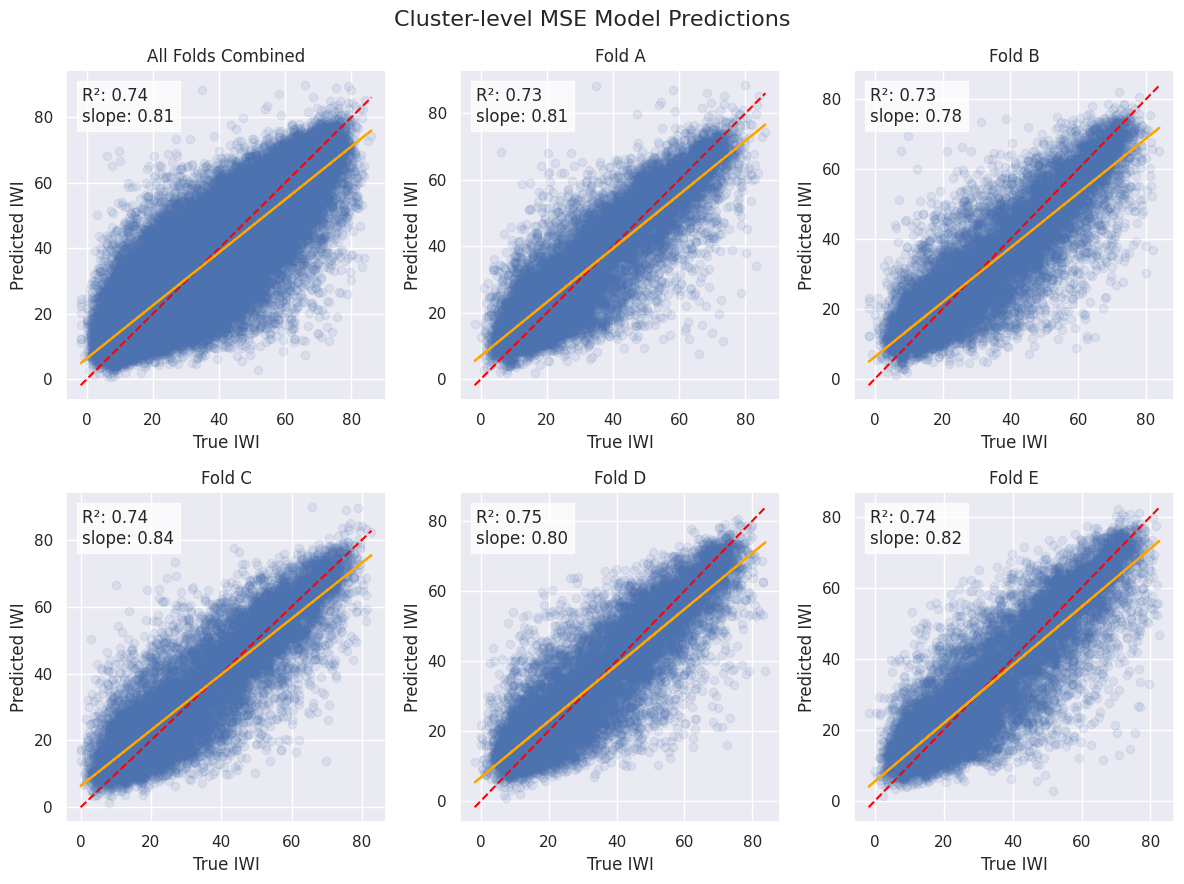

In [5]:
# Plot the sctatter plots for each fold in subplots
plt.figure(figsize=(12, 9))

plt.subplot(2, 3, 1)
plt.scatter(df['iwi'], df['iwi_hat'], alpha=0.1)
plt.plot([df['iwi'].min(), df['iwi'].max()], [df['iwi'].min(), df['iwi'].max()], color='red', linestyle='--')

# Add a box with R^2 and RMSE
r2 = r2_score(df['iwi'], df['iwi_hat'])
slope_model = LinearRegression().fit(df['iwi'].values.reshape(-1, 1), df['iwi_hat'])
plt.plot(df['iwi'], slope_model.predict(df['iwi'].values.reshape(-1, 1)), color='orange', label='Regression Line')
plt.text(0.05, 0.95, f'R²: {r2:.2f}\nslope: {slope_model.coef_[0]:.2f}', transform=plt.gca().transAxes,
            fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel('True IWI')
plt.ylabel('Predicted IWI')
plt.title(f'All Folds Combined')

for i, fold in enumerate(folds):
    plt.subplot(2, 3, i + 2)
    fold_data = df[df['cv_fold'] == fold]
    plt.scatter(fold_data['iwi'], fold_data['iwi_hat'], alpha=0.1)
    plt.plot([fold_data['iwi'].min(), fold_data['iwi'].max()], [fold_data['iwi'].min(), fold_data['iwi'].max()], color='red', linestyle='--')

    # Add a box with R^2 and RMSE
    r2 = r2_score(fold_data['iwi'], fold_data['iwi_hat'])
    slope_model = LinearRegression().fit(fold_data['iwi'].values.reshape(-1, 1), fold_data['iwi_hat'])
    plt.plot(fold_data['iwi'], slope_model.predict(fold_data['iwi'].values.reshape(-1, 1)), color='orange', label='Regression Line')
    plt.text(0.05, 0.95, f'R²: {r2:.2f}\nslope: {slope_model.coef_[0]:.2f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    plt.xlabel('True IWI')
    plt.ylabel('Predicted IWI')
    plt.title(f'Fold {fold}')
plt.suptitle('Cluster-level MSE Model Predictions', fontsize=16)
plt.tight_layout()
plt.show()